This script compares the distances between the CNEs and their closest genes in axolotl and human

In [10]:
opts_hg19 = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/hg19.annotation.gtf']
opts_amex = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/AmexT_v47.FULL.gtf']
opts_cnes = ['/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/compare_TADs/homologous_TADs.hg19_vs_amex.with_CNEs.list']
opts_sam =  ['/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/rebuttal/TADs_and_CNEs/merged.lastz.5.sam']

In [46]:
import os
import sys
import re
import pandas as pd

def loadGenes(gtfFile):
    genes = []
    with(open(gtfFile, 'r')) as hFile:
        for line in hFile.readlines():
            if line.startswith('#'):
                continue
            chrName, _, entryType, start, end, _, strand, _, attr = line.split('\t')
            if entryType != 'gene' or not chrName.startswith('chr'):
                continue
            m = re.search('gene_type "protein_coding";.+; gene_name "([^"]+)"', attr)
            if m:
                genes.append([chrName, int(start), int(end), m.group(1)])
            else:
                m = re.search('gene_id "AMEX60.+; gene_name "([^"]+)"', attr)
                if m:
                    for symbol in m.group(1).split('|'):
                        if not symbol.startswith('AMEX'):
                            if symbol.endswith('.L') or symbol.endswith('.S'):
                                symbol = symbol[:-2]
                            genes.append([chrName, int(start), int(end), symbol.replace(' [nr]', '').replace(' [hs]', '')])
    return pd.DataFrame(data=genes, columns=['chr', 'start', 'end', 'symbol'])


def loadTADs(file):
    cnes = dict()
    with(open(file, 'r')) as hFile:
        for line in hFile.readlines():
            tad_hg, cnes_hg, _, tad_am, _ = line.split('\t')
            if cnes_hg == 'N/A':
                continue
                
            m = re.search('chr[^:]+:([0-9]+)-([0-9]+)', tad_hg)
            hg_size = int(m.group(2)) - int(m.group(1))
            
            m = re.search('chr[^:]+[pq]:([0-9]+)-([0-9]+)', tad_am)
            am_size = int(m.group(2))  - int(m.group(1))
            
            for m in re.findall('chr[^:]+:[0-9]+-[0-9]+', cnes_hg):
                cnes[m] = [hg_size, am_size]
            
    return cnes


def loadCNEs(samFile):
    data = []
    with(open(samFile, 'r')) as hFile:
        for line in hFile.readlines():
            cne_hg, _, chr_amex, start_amex, _ = line.split('\t', 4)
            chr_hg, start_hg, end_hg = cne_hg.split('_')
            data.append({'chr_hg': chr_hg, 'start_hg': int(start_hg), 'end_hg': int(end_hg), 'chr_amex': chr_amex, 'start_amex': int(start_amex)})
    return data


In [47]:
print(f"Reading the human genes from '{opts_hg19[0]}'", file=sys.stderr)
genes_hg = loadGenes(opts_hg19[0])
print(f'  Loaded {genes_hg["chr"].count()} genes', file=sys.stderr)

print(f"Reading the axolotl genes from '{opts_amex[0]}'", file=sys.stderr)
genes_amex = loadGenes(opts_amex[0])
print(f'  Loaded {genes_amex["chr"].count()} genes', file=sys.stderr)

print(f"Reading the TADs from '{opts_cnes[0]}'", file=sys.stderr)
tads = loadTADs(opts_cnes[0])
print(f'  Loaded {len(tads)} TADs with CNEs', file=sys.stderr)

print(f"Reading the CNEs mapping data from '{opts_sam[0]}'", file=sys.stderr)
cnes = loadCNEs(opts_sam[0])
print(f'  Loaded {len(cnes)} CNEs', file=sys.stderr)

Reading the human genes from '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/hg19.annotation.gtf'
  Loaded 20345 genes
Reading the axolotl genes from '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/AmexT_v47.FULL.gtf'
  Loaded 38160 genes
Reading the TADs from '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/compare_TADs/homologous_TADs.hg19_vs_amex.with_CNEs.list'
  Loaded 883 TADs with CNEs
Reading the CNEs mapping data from '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/rebuttal/TADs_and_CNEs/merged.lastz.5.sam'
  Loaded 171 CNEs


In [48]:
# Find the closest gene for each CNE in both human and axolotl
nNoClosest_hg = 0
nNoClosest_amex = 0
nSameClosest = 0
nDiffClosest = 0
distances = {'hg': [], 'am': [], 'symbols': []}
tad_sizes = {'hg': [], 'am': [], 'symbols': []}
for cne in cnes:
    closest_hg = {'chr': None, 'start': -1, 'end': -1, 'symbol': None, 'distance': -1}
    closest_amex = {'chr': None, 'start': -1, 'end': -1, 'symbol': None, 'distance': -1}
    _genes_hg = genes_hg[genes_hg['chr'] == cne['chr_hg']]
    for idx in _genes_hg.index:
        d = abs(_genes_hg['start'][idx] - cne['start_hg'])
        if closest_hg['distance'] == -1 or d < closest_hg['distance']:
            closest_hg = {'chr': _genes_hg['chr'][idx], 
                          'start': _genes_hg['start'][idx], 
                          'end': _genes_hg['end'][idx], 
                          'symbol': _genes_hg['symbol'][idx], 
                          'distance': d}
            
    if closest_hg['distance'] == -1:
        nNoClosest_hg += 1
        continue
        
    _genes_amex = genes_amex[genes_amex['chr'] == cne['chr_amex']]
    for idx in _genes_amex.index:
        d = abs(_genes_amex['start'][idx] - cne['start_amex'])
        if closest_amex['distance'] == -1 or d < closest_amex['distance']:
            closest_amex = {'chr': _genes_amex['chr'][idx], 
                            'start': _genes_amex['start'][idx], 
                            'end': _genes_amex['end'][idx], 
                            'symbol': _genes_amex['symbol'][idx], 
                            'distance': d}
            
    if closest_amex['distance'] == -1:
        nNoClosest_amex += 1
        continue
        
    if closest_amex['symbol'] == closest_hg['symbol']:
        nSameClosest += 1
        distances['symbols'].append(closest_hg['symbol'])
        distances['hg'].append(closest_hg['distance'])
        distances['am'].append(closest_amex['distance'])
        tmp = tads[f"{cne['chr_hg']}:{cne['start_hg']}-{cne['end_hg']}"]
        tad_sizes['hg'].append(tmp[0])
        tad_sizes['am'].append(tmp[1])
        
    else:
        nDiffClosest += 1
        #print(f"CNE: {cne}. Hg: {closest_hg}, Am: {closest_amex}",  file=sys.stderr)
        
print(f"No closest gene in human: {nNoClosest_hg}", file=sys.stderr)
print(f"No closest gene in axolotl: {nNoClosest_amex}", file=sys.stderr)
print(f"Different closest in human and axolotl: {nDiffClosest}", file=sys.stderr)
print(f"Same closest in human and axolotl: {nSameClosest}", file=sys.stderr) 
print(distances['hg'])
print(distances['am'])
print(distances['symbols'])

[88955, 29286, 49612, 2740, 6104, 42770, 5266, 166777, 187220, 32759, 97414, 121102, 2706, 2740, 35796, 24988, 36808, 6104, 32105, 252283, 196929, 8638, 109272, 51562, 214476, 1278, 413689, 9047, 12875, 4711, 222863, 192180, 23978, 9426, 1278, 41660, 222863, 213664, 81655, 75914, 33908, 574, 283657, 93523, 222463, 165482, 11321, 28990, 37136, 8638, 85489, 5635, 32202, 33614, 9047, 166198, 332009, 9426, 3097, 4630, 22016, 19138, 223237, 214423, 223487, 260045, 5635, 1278, 271945, 23569, 19929, 12875, 332009, 46451, 205019, 137469, 283657, 16335, 4553, 286574, 43894, 99278]
[77383, 447350, 669648, 5691, 12297, 716667, 248634, 513254, 1416674, 651159, 632155, 417860, 485095, 5691, 22182, 145322, 124131, 12297, 57667, 400634, 109019, 424479, 297546, 541824, 1313756, 11062, 9500, 69801, 175417, 362420, 793442, 105988, 74229, 38402, 11062, 322435, 793442, 280481, 859240, 69097, 461295, 42385, 2112600, 179031, 654257, 322762, 1668049, 72458, 1535, 424479, 171676, 21432, 301089, 264817, 69801,

No closest gene in human: 0
No closest gene in axolotl: 0
Different closest in human and axolotl: 89
Same closest in human and axolotl: 82


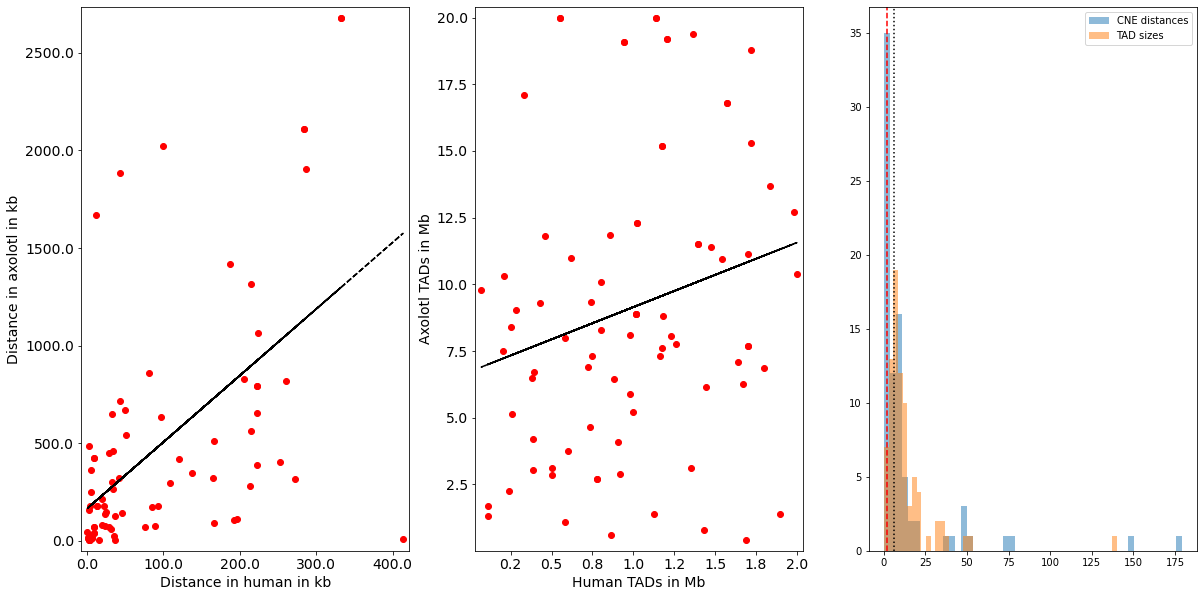

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,10))

# CNE distances
x = distances['hg']
y = distances['am']
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 
axs[0].plot(x, y, 'ro', x, poly1d_fn(x), '--k')

plt.sca(axs[0])
xticks, xlabels = plt.xticks()
xlabels_new = []
for x in xticks:
    xlabels_new.append(f'{x / 1000:.1f}')
xlabels_new[0] = ''
xlabels_new[-1] = ''
plt.xticks(xticks, xlabels_new, fontsize=14)
plt.xlabel('Distance in human in kb', fontsize=14)

yticks, ylabels = plt.yticks()
ylabels_new = []
for y in yticks:
    ylabels_new.append(f'{y / 1000:.1f}')
ylabels_new[0] = ''
ylabels_new[-1] = ''
plt.yticks(yticks, ylabels_new, fontsize=14)
plt.ylabel('Distance in axolotl in kb', fontsize=14)

plt.margins(0.02)

# TAD sizes
x = tad_sizes['hg']
y = tad_sizes['am']
coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 
axs[1].plot(x, y, 'ro', x, poly1d_fn(x), '--k')

plt.sca(axs[1])
xticks, xlabels = plt.xticks()
xlabels_new = []
for x in xticks:
    xlabels_new.append(f'{x / 1_000_000:.1f}')
xlabels_new[0] = ''
xlabels_new[-1] = ''
plt.xticks(xticks, xlabels_new, fontsize=14)
plt.xlabel('Human TADs in Mb', fontsize=14)

yticks, ylabels = plt.yticks()
ylabels_new = []
for y in yticks:
    ylabels_new.append(f'{y / 1_000_000:.1f}')
ylabels_new[0] = ''
ylabels_new[-1] = ''
plt.yticks(yticks, ylabels_new, fontsize=14)
plt.ylabel('Axolotl TADs in Mb', fontsize=14)

plt.margins(0.02)


tmp = [am / hg for hg, am in zip(distances['hg'], distances['am'])]
axs[2].hist(tmp, bins=50, alpha=0.5, label='CNE distances')
tmp = [am / hg for hg, am in zip(tad_sizes['hg'], tad_sizes['am'])]
axs[2].hist(tmp, bins=50, alpha=0.5, label='TAD sizes')
axs[2].axvline(2, linestyle='dashed', color='red')
axs[2].axvline(6, linestyle='dotted', color='black')
plt.sca(axs[2])
plt.legend()

(array([31., 30., 11.,  2.,  2.,  3.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  0.23668594,   7.22495093,  14.21321592,  21.20148091,
         28.1897459 ,  35.17801089,  42.16627588,  49.15454087,
         56.14280586,  63.13107085,  70.11933584,  77.10760083,
         84.09586582,  91.08413081,  98.0723958 , 105.06066079,
        112.04892578, 119.03719077, 126.02545576, 133.01372075,
        140.00198574]),
 <BarContainer object of 20 artists>)

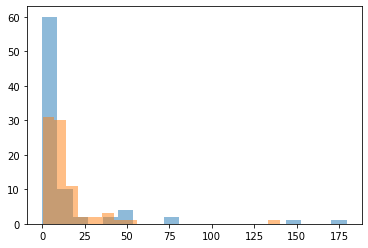